In [ ]:
import pandas as pd
import numpy as np
import torch, pickle

In [ ]:
torch.sigmoid(torch.randn(2))

tensor([0.7872, 0.1560])

## Module

In [ ]:
import torch.nn.functional as F
class DNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out, nb_h_layers, dropout = 0):
        super(DNN, self).__init__()
        nn_list = []
        # hidden layer
        for i in range(nb_h_layers):
            if i == 0:
                nn_list.append(torch.nn.Linear(D_in, H))
            else:
                nn_list.append(torch.nn.Linear(H, H))
        # output layer
        nn_list.append(torch.nn.Linear(H, D_out))

        self.nb_layers = nb_h_layers + 1
        self.layer_list = torch.nn.ModuleList(nn_list)
        self.dropout = torch.nn.Dropout(dropout, inplace = True)

    def forward(self, x):
        # hidden layer
        for i in range(self.nb_layers - 1):
            x = F.relu(self.layer_list[i](x))
            self.dropout(x)
        # output layer
        x = self.layer_list[self.nb_layers - 1](x)
        return torch.sigmoid(x)

    def predict(self, x):
        result = self.forward(x)
        return (result)

## Loss Function

In [ ]:
# def MSFE(outputs, targets):
#     # False positive
#     fp_index = (targets == 0)
#     FPE = ((outputs[fp_index] - targets[fp_index])**2/sum(fp_index)).sum()
#     # False negative
#     fn_index = (targets == 1)
#     FNE = ((outputs[fn_index] - targets[fn_index])**2/sum(fn_index)).sum()
#     print('FPE =%f, FNE = %f' %(FPE, FNE))
#     print('FP =%f, FN = %f' %(sum(fp_index), sum(fn_index)))
#     return FPE**2+FNE**2

def MSFE(outputs, targets):
    # True label
    fp_index = (targets[:, 1] == 1)
    FPE = ((outputs[fp_index, :] - targets[fp_index, :])**2).mean()
    # False label
    fn_index = (targets[:, 0] == 1).nonzero()
    FNE = ((outputs[fn_index, :] - targets[fn_index, :])**2).mean()

    return FPE**2+FNE**2

## Load data

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = 'cuda'
else:
    device = 'cpu'
print('device: %s' %device)

device: cuda


In [ ]:
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/Colab Notebooks/統計學習與深度學習/project/imb.pickle','rb') as handle:
    under_data = pickle.load(handle)

X_subtrain = under_data['X_subtrain']
X_valid = under_data['X_valid']
X_test = under_data['X_test']
y_subtrain_1 = under_data['y_subtrain'].reshape(-1, 1)
y_valid_1 = under_data['y_valid'].reshape(-1, 1)
y_test_1 = under_data['y_test'].reshape(-1, 1)

# 把 y 變成二維
y_subtrain_zero = np.ones((y_subtrain_1.shape[0], 1)) - y_subtrain_1
y_subtrain = np.concatenate([y_subtrain_1, y_subtrain_zero], axis = 1)

y_valid_zero = np.ones((y_valid_1.shape[0], 1)) - y_valid_1
y_valid = np.concatenate([y_valid_1, y_valid_zero], axis = 1)

y_test_zero = np.ones((y_test_1.shape[0], 1)) - y_test_1
y_test = np.concatenate([y_test_1, y_test_zero], axis = 1)

# x 標準化
std_scaler = StandardScaler()
X_subtrain = std_scaler.fit_transform(X_subtrain)
X_valid = std_scaler.transform(X_valid)
X_test = std_scaler.transform(X_test)

use_cuda = torch.cuda.is_available()
if use_cuda:
    device = 'cuda'
else:
    device = 'cpu'
print('device: %s' %device)

X_subtrain_tensor = torch.tensor(X_subtrain, dtype=torch.float).to(device)
y_subtrain_tensor = torch.tensor(y_subtrain, dtype=torch.float).to(device)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float).to(device)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

Mounted at /content/drive
device: cuda


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.nobs = X.shape[0]
    def __len__(self): # get number of observations
        return self.nobs
    def __getitem__(self, index):
        X_i = self.X[index]
        y_i = self.y[index]
        return X_i, y_i

In [ ]:
subtrainset = Dataset(X_subtrain_tensor, y_subtrain_tensor)
subtrainloader = torch.utils.data.DataLoader(subtrainset, batch_size = 10000, shuffle=True, num_workers=0)

### Model training

In [ ]:
import numpy as np
np.logspace(-6, -1, 4)

array([1.00000000e-06, 4.64158883e-05, 2.15443469e-03, 1.00000000e-01])

In [ ]:
from sklearn.metrics import confusion_matrix
result_pd = pd.DataFrame()

# constant
max_epoch = 500
log_interval = 50
max_bacth_wait = 30

# tuning parameters
lr_rates = [0.1]#np.logspace(-6, -1, 4) # 4
dropout_rates = [0.5] # 1
Hs = [i * X_subtrain.shape[1] for i in range(3, 5)] # 4
nb_h_layers = range(1,5)# 4


for lr_rate in lr_rates:
  for H in Hs:
    for dropout_rate in dropout_rates:
      for nb_h_layer in nb_h_layers:
        # variables
        step_index = 0
        batch_wait = 0
        subtrain_MSFEs = []
        valid_MSFEs = []
        best_valid_MSFE = -1
        best_state_dict = -1

        net = DNN(X_subtrain.shape[1], H, 2, nb_h_layer, dropout = dropout_rate).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr = lr_rate)
        loss_function = torch.nn.MSELoss(reduction = 'sum')

        for epoch in range(max_epoch):
            for batch_index, (inputs, targets) in enumerate(subtrainloader):
                inputs = inputs.to(device)
                targets = targets.to(device)#.reshape(-1, 1)
                #print('targets.shape:', targets.shape)
                step_index += 1
                net.train()
                optimizer.zero_grad()
                outputs = net(inputs)
                #outputs.requires_grad = True
                #loss = MSFE(outputs, targets)
                loss = MSFE(outputs, targets)
                loss.backward()
                optimizer.step()

        #         net.eval()
        #         pred = net.predict(X_subtrain_tensor).to('cpu').numpy()
        #         print(confusion_matrix(y_subtrain, pred))

                if step_index % log_interval == 0:
                    net.eval()
                    #print(net.state_dict()['layer_list.0.weight'])
                    with torch.no_grad():
                        # subtraining loss
                        #pred = net.predict(X_subtrain_tensor).to('cpu').numpy()
                        #print(confusion_matrix(y_subtrain, pred))
                        outputs = net(X_subtrain_tensor)
                        subtrain_MSFE = MSFE(outputs, y_subtrain_tensor)

                        # validation loss
                        outputs = net(X_valid_tensor)
                        valid_MSFE = MSFE(outputs, y_valid_tensor)
                        if valid_MSFE < best_valid_MSFE or best_valid_MSFE  == -1:
                            best_valid_MSFE = valid_MSFE
                            best_state_dict = net.state_dict().copy()
                            batch_wait = 0
                        else:
                            batch_wait += 1

                        subtrain_MSFEs.append(subtrain_MSFE)
                        valid_MSFEs.append(valid_MSFE)
                        print('Epoch = %d, step = %d, subtrain MSFE = %f, valid MSFE = %f, batch_wait = %d'
                              %(epoch, step_index, subtrain_MSFE, valid_MSFE, batch_wait))

                if batch_wait == max_bacth_wait:
                  break

            if batch_wait == max_bacth_wait:
              break
        result_series = pd.Series({'lr_rate':lr_rate, 'H':H, 'dropout_rate': dropout_rate, 'nb_h_layers': nb_h_layer,
                                    'best_valid_MSFE': best_valid_MSFE.item()})
        result_pd = result_pd.append(result_series, ignore_index=True)
        print('lr%f_H%d_d%0.1f_hl%d best_valid MSFE: %f'%(lr_rate, H, dropout_rate, nb_h_layer, best_valid_MSFE.item()))
        net.load_state_dict(best_state_dict)
        torch.save(net, '/content/drive/My Drive/Colab Notebooks/統計學習與深度學習/project/DNN_models_ver2/lr%f_H%d_d%0.1f_hl%d'%(lr_rate, H, dropout_rate, nb_h_layer))
        result_pd.to_csv('/content/drive/My Drive/Colab Notebooks/統計學習與深度學習/project/DNN_result_2.csv',index = False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


Epoch = 2, step = 50, subtrain MSFE = 19296756.000000, valid MSFE = 112762.867188, batch_wait = 0
Epoch = 4, step = 100, subtrain MSFE = 681182272.000000, valid MSFE = 54979012.000000, batch_wait = 1
Epoch = 7, step = 150, subtrain MSFE = 71180886016.000000, valid MSFE = 1669182464.000000, batch_wait = 2
Epoch = 9, step = 200, subtrain MSFE = 85256142848.000000, valid MSFE = 2549349120.000000, batch_wait = 3
Epoch = 11, step = 250, subtrain MSFE = 83622551552.000000, valid MSFE = 28678811648.000000, batch_wait = 4
Epoch = 14, step = 300, subtrain MSFE = 39813398528.000000, valid MSFE = 15589062656.000000, batch_wait = 5
Epoch = 16, step = 350, subtrain MSFE = 411458568192.000000, valid MSFE = 218192920576.000000, batch_wait = 6
Epoch = 19, step = 400, subtrain MSFE = 320219676672.000000, valid MSFE = 130203369472.000000, batch_wait = 7
Epoch = 21, step = 450, subtrain MSFE = 1493906227200.000000, valid MSFE = 486980583424.000000, batch_wait = 8
Epoch = 23, step = 500, subtrain MSFE = 3

In [ ]:
result_pd.to_csv('/content/drive/My Drive/Colab Notebooks/統計學習與深度學習/project/DNN_result.csv',index = False)

In [ ]:
a = torch.load('/content/drive/My Drive/Colab Notebooks/統計學習與深度學習/project/DNN_models/lr0.000001_H90_d0.1_hl4')

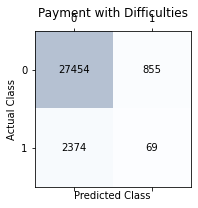

accuracy = 0.8949986992715921
f1_score = 0.040986040986040986
precision = 0.07467532467532467
recall = 0.028243962341383544


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

#net.load_state_dict(best_state_dict)
a.eval()
result = a.predict(X_test_tensor).to('cpu')
y_test = y_test_1
plt_title = 'Payment with Difficulties'

from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test, y_pred=result)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title(plt_title)
plt.tight_layout()
plt.savefig('under_sampling_confusion_matrix.png', transparent = True)
plt.show()


acc = accuracy_score(y_test, result)
f1 = f1_score(y_test, result)
precision = precision_score(y_test, result)
recall = recall_score(y_test, result)
#spe = specificity_score(y_test, result)
#opt = opt_score(y_test, result)
print('accuracy =', acc)
print('f1_score =', f1)
print('precision =', precision)
print('recall =', recall)
#print('specificity =', spe)
#print('opt_score =', opt)

In [ ]:
input1.shape

torch.Size([2])

In [ ]:
a = np.array([[1,2,3], [6,6,6]])
a[1, :]

array([6, 6, 6])